In [1]:
import numpy as np
import scipy.sparse as sp
import ReservoirComputer3_2 as ReCom
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import ipywidgets as widgets
from scipy.interpolate import splprep, splev
from scipy import stats
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import cm
import ReservoirPlot as resplt

## Define functions needed for data generation and simulations:

In [2]:
def lorenz(u, *args):
    x, y, z = u[0], u[1], u[2]
    beta, rho, sigma = alpha[0], alpha[1], alpha[2]
    
    return np.asarray([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])


def plot_traj(traj, t_start=0, t_end=15000, xlim=300, ylim=300, zlim=300):
    fig = plt.figure(figsize=(15,9))
    ax = fig.gca(projection="3d")
    t_start = int(t_start)
    t_end = int(t_end)
    for i in range(len(traj)-1):
        u = traj[i]
        ax.plot(u[t_start:t_end, 0], u[t_start:t_end, 1], u[t_start:t_end, 2], "b-",
                markersize=2.0, alpha=0.5)
    u = traj[len(traj)-1]
    ax.plot(u[t_start:t_end, 0], u[t_start:t_end, 1], u[t_start:t_end, 2], "r-",
            markersize=2.0, alpha=0.5)
    for i in range(len(traj)):
        u = traj[i]
        ax.plot(u[t_end-1, 0], u[t_end-1, 1], u[t_end-1, 2], "ko",
                markersize=2.0, alpha=1.0)
    
    
    ax.set_xlim3d(-xlim, xlim)
    ax.set_ylim3d(-ylim, ylim)
    ax.set_zlim3d(0,zlim)

    
def evolve(RC, ics, t_points):
    ics = ics.copy()
    ics.append(RC.r_T)
    traj = np.zeros((len(ics), len(t_points), RC.d))
    
    for i in range(len(ics)):
        r0 = ics[i]
        PR_traj = integrate.odeint(RC.f_PR, r0, t_points)
        prediction = np.asarray([RC.W_out.dot(RC.q(p)) for p in PR_traj])
        traj[i,:,:] = prediction
    
    return traj 


def eta_epoch_grid_search(RC, train_data, t_points, t_listen, scale_M, ics, eta_list, epochs_list):
    predictions = np.zeros((eta_list.size ,epochs_list.size + 1 ,len(ics) + 1, t_points.size, RC.d))
    
    for i in range(eta_list.size):
        for j in range(epochs_list.size):
            print(eta_list[i], epochs_list[j])
            RC.eta = eta_list[i]
            RC.epochs = epochs_list[j]
            RC.SP_train(train_data, t_points_training, t_listen, True, scale_M)    
            training_traj = RC.train(train_data, t_points_training, t_listen)
            pert_traj = evolve(RC, ics, t_points)
            predictions[i, j,:,:,:] = pert_traj

    return predictions

## Generate training and validation data for Lorenz System:

In [3]:
T_train = 100
T_predict = 150
dt = 0.01
alpha = (8.0/3.0, 28.0, 10.0)
x0 = np.asarray([1.0, 1.0, 1.0])
t_points_training = np.linspace(0, T_train, int(T_train/dt))
t_points_prediction = np.linspace(0, T_predict, int(T_predict/dt))
train_data = integrate.odeint(lorenz, x0, t_points_training, args=alpha)
val_data = integrate.odeint(lorenz, train_data[-1], t_points_prediction, args=alpha)

Wall time: 43.5 s


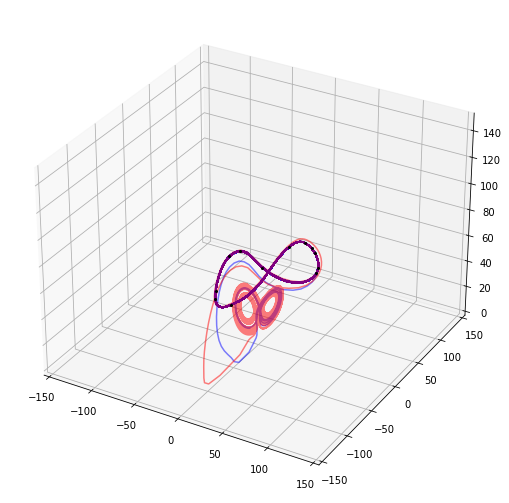

In [7]:
%%time
RC = ReCom.ESN(N=100, p=0.01, d=3, rho=0.6, sigma=0.6, gamma=10.0, beta=1e-6)
training_traj = RC.train(train_data, t_points_training, t_listen=5000)
ics = list(np.random.uniform(low=-1, high=1, size=(20,100)))
trajectories = evolve(RC, ics, t_points_prediction)
plot_traj(trajectories, t_start=1000, t_end=15000, xlim=150, ylim=150, zlim=150)

In [5]:
RC = ReCom.SPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta=0, epochs=0)

In [6]:
%%time 
training_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction = RC.predict(t_points_prediction)

Wall time: 2.33 s


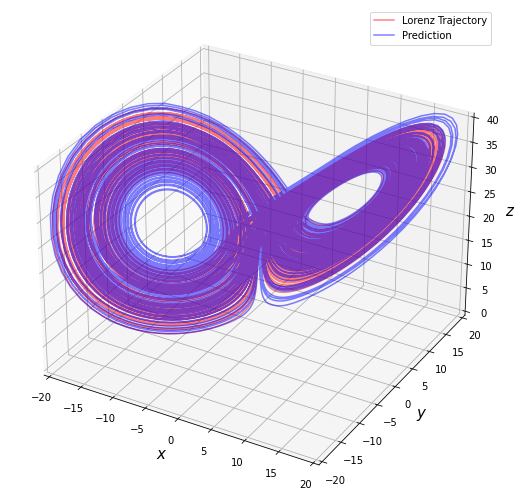

In [7]:
%matplotlib inline
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
ax1.plot(prediction[:-1,0], prediction[:-1,1], prediction[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction')

xlim, ylim, zlim = 20, 20, 40
ax1.set_xlim(-xlim, xlim)
ax1.set_ylim(-ylim, ylim)
ax1.set_zlim(0, zlim)
ax1.set_xlabel('$x$', fontsize=15)
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_zlabel('$z$', fontsize=15)
ax1.legend()

## Perform $\eta$, epoch parameter sweeps for different types of Hebbian learning rule:

In [8]:
# Grid search for optimal eta, epoch values
eta_list = np.asarray([1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
epochs_list = np.arange(1, 11)

In [9]:
%%time
# Don't scale M during training.
trajectories_unscaled = eta_epoch_grid_search(RC, train_data, 
                                              t_points_prediction, 
                                              5000,
                                              0,
                                              ics, 
                                              eta_list, 
                                              epochs_list)

1e-09 1
1e-09 2
1e-09 3
1e-09 4
1e-09 5
1e-09 6
1e-09 7
1e-09 8
1e-09 9
1e-09 10
1e-08 1
1e-08 2
1e-08 3
1e-08 4
1e-08 5
1e-08 6
1e-08 7
1e-08 8
1e-08 9
1e-08 10
1e-07 1
1e-07 2
1e-07 3
1e-07 4
1e-07 5
1e-07 6
1e-07 7
1e-07 8
1e-07 9
1e-07 10
1e-06 1
1e-06 2
1e-06 3
1e-06 4
1e-06 5
1e-06 6
1e-06 7
1e-06 8
1e-06 9
1e-06 10
1e-05 1
1e-05 2
1e-05 3
1e-05 4
1e-05 5
1e-05 6
1e-05 7
1e-05 8
1e-05 9
1e-05 10
0.0001 1
0.0001 2
0.0001 3
0.0001 4
0.0001 5
0.0001 6
0.0001 7
0.0001 8
0.0001 9
0.0001 10
0.001 1
0.001 2
0.001 3
0.001 4
0.001 5
0.001 6
0.001 7
0.001 8
0.001 9
0.001 10
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7


C:\Users\foxda\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.01 8
0.01 9
0.01 10
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.1 10
1.0 1
1.0 2
1.0 3
1.0 4
1.0 5
1.0 6
1.0 7
1.0 8
1.0 9
1.0 10
Wall time: 2h 28min 24s


In [10]:
%store trajectories_unscaled

Stored 'trajectories_unscaled' (ndarray)


In [ ]:
%store -r trajectories_unscaled

In [12]:
%%time
#Scale after each epoch
trajectories_scaled_epoch = eta_epoch_grid_search(RC, train_data, 
                                     t_points_prediction, 
                                     5000,
                                     1,
                                     ics, 
                                     eta_list, 
                                     epochs_list)

1e-09 1
1e-09 2
1e-09 3
1e-09 4
1e-09 5
1e-09 6
1e-09 7
1e-09 8
1e-09 9
1e-09 10
1e-08 1
1e-08 2
1e-08 3
1e-08 4
1e-08 5
1e-08 6
1e-08 7
1e-08 8
1e-08 9
1e-08 10
1e-07 1
1e-07 2
1e-07 3
1e-07 4
1e-07 5
1e-07 6
1e-07 7
1e-07 8
1e-07 9
1e-07 10
1e-06 1
1e-06 2
1e-06 3
1e-06 4
1e-06 5
1e-06 6
1e-06 7
1e-06 8
1e-06 9
1e-06 10
1e-05 1
1e-05 2
1e-05 3
1e-05 4
1e-05 5
1e-05 6
1e-05 7
1e-05 8
1e-05 9
1e-05 10
0.0001 1
0.0001 2
0.0001 3
0.0001 4
0.0001 5
0.0001 6
0.0001 7
0.0001 8
0.0001 9
0.0001 10
0.001 1
0.001 2
0.001 3
0.001 4
0.001 5
0.001 6
0.001 7
0.001 8
0.001 9
0.001 10
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9
0.01 10
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.1 10
1.0 1
1.0 2
1.0 3
1.0 4
1.0 5
1.0 6
1.0 7
1.0 8
1.0 9
1.0 10
Wall time: 1h 4min 48s


In [13]:
%store trajectories_scaled_epoch

Stored 'trajectories_scaled_epoch' (ndarray)


In [ ]:
%store -r trajectories_scaled_epoch

In [15]:
%%time
# Scale once at the end of training.
trajectories_scaled_end = eta_epoch_grid_search(RC, train_data, 
                                     t_points_prediction, 
                                     5000,
                                     2,
                                     ics, 
                                     eta_list, 
                                     epochs_list)

1e-09 1
1e-09 2
1e-09 3
1e-09 4
1e-09 5
1e-09 6
1e-09 7
1e-09 8
1e-09 9
1e-09 10
1e-08 1
1e-08 2
1e-08 3
1e-08 4
1e-08 5
1e-08 6
1e-08 7
1e-08 8
1e-08 9
1e-08 10
1e-07 1
1e-07 2
1e-07 3
1e-07 4
1e-07 5
1e-07 6
1e-07 7
1e-07 8
1e-07 9
1e-07 10
1e-06 1
1e-06 2
1e-06 3
1e-06 4
1e-06 5
1e-06 6
1e-06 7
1e-06 8
1e-06 9
1e-06 10
1e-05 1
1e-05 2
1e-05 3
1e-05 4
1e-05 5
1e-05 6
1e-05 7
1e-05 8
1e-05 9
1e-05 10
0.0001 1
0.0001 2
0.0001 3
0.0001 4
0.0001 5
0.0001 6
0.0001 7
0.0001 8
0.0001 9
0.0001 10
0.001 1
0.001 2
0.001 3
0.001 4
0.001 5
0.001 6
0.001 7
0.001 8
0.001 9
0.001 10
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9
0.01 10
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.1 10
1.0 1
1.0 2
1.0 3
1.0 4
1.0 5
1.0 6
1.0 7
1.0 8
1.0 9
1.0 10
Wall time: 2h 15min 10s


In [16]:
%store trajectories_scaled_end

Stored 'trajectories_scaled_end' (ndarray)


In [6]:
%store -r trajectories_scaled_end

In [11]:
%matplotlib inline
@widgets.interact(i=(0, 9, 1), j=(0, 9, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=0, t_start=1000, t_end=15000, xlim=50, ylim=50, zlim=50):
    fig = plt.figure(figsize=(15,9))  
    plot_traj(trajectories_unscaled[i,j], t_start, t_end, xlim, ylim, zlim)
    
    print("Eta = " + str(eta_list[i]))
    print("Epoch = " + str(epochs_list[j]))

interactive(children=(IntSlider(value=0, description='i', max=9), IntSlider(value=0, description='j', max=9), …

In [14]:
%matplotlib inline
@widgets.interact(i=(0, 9, 1), j=(0, 9, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=0, t_start=1000, t_end=15000, xlim=50, ylim=50, zlim=50):
    fig = plt.figure(figsize=(15,9))  
    plot_traj(trajectories_scaled_epoch[i,j], t_start, t_end, xlim, ylim, zlim)
    
    print("Eta = " + str(eta_list[i]))
    print("Epoch = " + str(epochs_list[j]))

interactive(children=(IntSlider(value=0, description='i', max=9), IntSlider(value=0, description='j', max=9), …

In [17]:
%matplotlib inline
@widgets.interact(i=(0, 9, 1), j=(0, 9, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=0, t_start=1000, t_end=15000, xlim=50, ylim=50, zlim=50):
    fig = plt.figure(figsize=(15,9))  
    plot_traj(trajectories_scaled_end[i,j], t_start, t_end, xlim, ylim, zlim)
    
    print("Eta = " + str(eta_list[i]))
    print("Epoch = " + str(epochs_list[j]))

interactive(children=(IntSlider(value=0, description='i', max=9), IntSlider(value=0, description='j', max=9), …

## Best  result was unscaled rule with ($\eta_{s}$ , epoch) values (1e-6, 10)

In [25]:
RC = ReCom.SPESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6, eta=1e-6, epochs=10)

In [19]:
%%time
train_traj = RC.train(train_data, t_points_training, t_listen=5000)

Wall time: 1.41 s


In [20]:
%%time
prediction_orig = RC.predict(t_points_prediction)

Wall time: 3.11 s


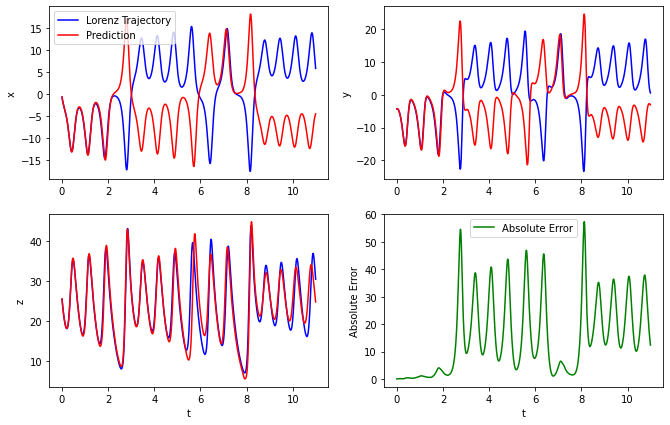

In [21]:
resplt.plot_short_pred(val_data, prediction_orig, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)

In [26]:
%%time
RC.SP_train(train_data, t_points_training, t_listen=5000)
sp_train_traj = RC.train(train_data, t_points_training, t_listen=5000)

Wall time: 20.4 s


In [27]:
%%time
prediction_sp = RC.predict(t_points_prediction)

Wall time: 1.35 s


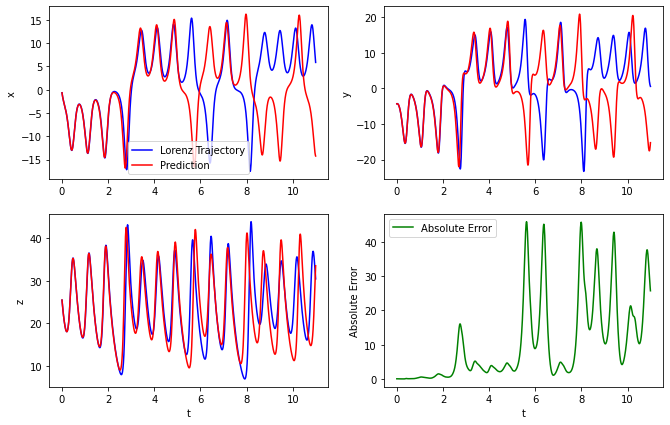

In [28]:
resplt.plot_short_pred(val_data, prediction_sp, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)

In [29]:
max_eval = np.abs(sp.linalg.eigs(RC.M, 1, which='LM', return_eigenvectors=False)[0])
max_eval
#RC2.M = (0.3/max_eval)*self.M

1.7778333154320922

In [31]:
RC.M.todense()

matrix([[-0.03464909, -0.01314455, -0.03241547, ...,  0.03509506,
          0.00599365,  0.0057115 ],
        [-0.01353743, -0.00773657, -0.01526031, ...,  0.01366539,
          0.00188686,  0.00295892],
        [-0.03293441, -0.01523687, -0.03701877, ...,  0.03342294,
          0.00667335,  0.00696251],
        ...,
        [ 0.03509464,  0.01327994,  0.03290268, ..., -0.03556077,
         -0.00611276, -0.00579933],
        [ 0.00599947,  0.00188865,  0.00667619, ..., -0.00611867,
         -0.04981426, -0.01176415],
        [ 0.00576655,  0.00298807,  0.00703093, ..., -0.00585567,
         -0.01176384, -0.00462892]])

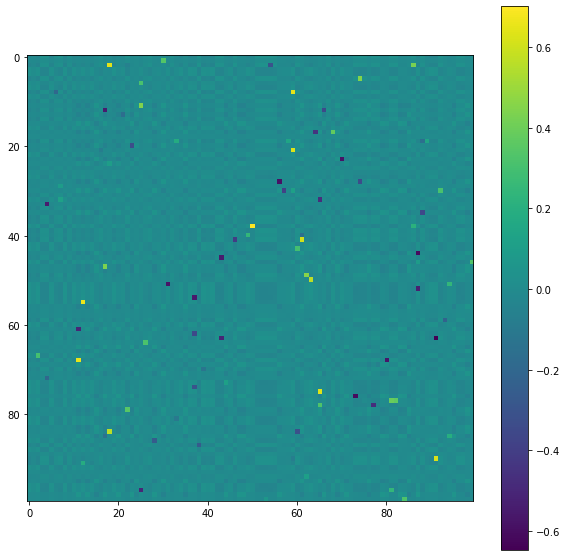

In [27]:
fig = plt.figure(figsize=(10,10))
plt.imshow(RC.M.todense().T)
plt.colorbar()

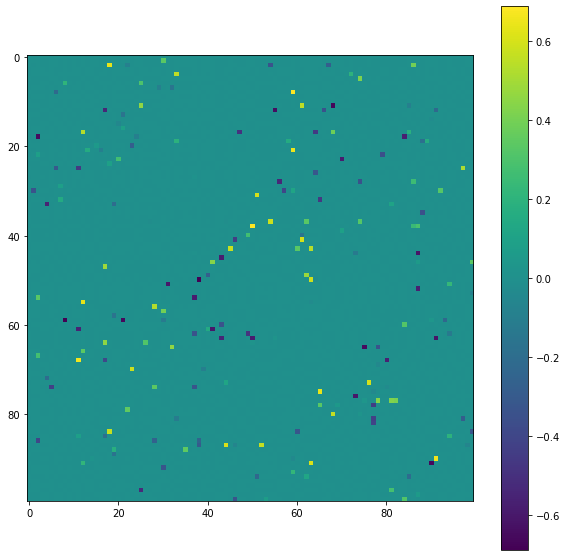

In [26]:
fig = plt.figure(figsize=(10,10))
plt.imshow(RC.M.todense().T - RC.M.todense())
plt.colorbar()

## Scale M matrix to have spectral radius 1:

<Figure size 1440x1440 with 0 Axes>

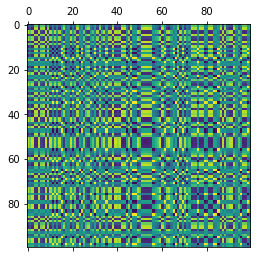

In [47]:
fig = plt.figure(figsize=(20,20))
plt.matshow(RC.M.todense())
plt.show()

In [16]:
M = 1/RC.rho*RC.M
max_eval = np.abs(sp.linalg.eigs(M, 1, which='LM', return_eigenvectors=False)[0])
RC.M = (RC.rho/max_eval)*M.copy()
np.abs(sp.linalg.eigs(RC.M, 1, which='LM', return_eigenvectors=False)[0])

0.3000000000000005

# Investigating the adjacency matrix M:

In [24]:
M = 1/RC.rho*RC.M
max_eval = np.abs(sp.linalg.eigs(M, 1, which='LM', return_eigenvectors=False)[0])
max_eval

9.642650045833594

In [51]:
M_dense = M.todense()
np.asarray(M_dense[0])[0]

array([[-0.1159729 , -0.06627471, -0.10546222,  0.11269265,  0.11638685,
        -0.10329702,  0.08140893,  0.11197654, -0.10902179,  0.09259136,
        -0.09896056, -0.1033289 , -0.10763318, -0.10097947, -0.09935896,
         0.10215681,  0.10435404, -0.10333835, -0.0243533 , -0.11022374,
        -0.10254743, -0.07021393,  0.1075801 , -0.103339  ,  0.08375957,
        -0.09940414,  0.07714776,  0.10663837, -0.10333858, -0.0601805 ,
         0.1033408 , -0.10294638,  0.09623416, -0.0582445 , -0.1137554 ,
         0.10188444, -0.11467747, -0.10802408,  0.11065019, -0.10871363,
        -0.09879417, -0.11115443,  0.10453089,  0.12096958, -0.10333914,
        -0.0995801 ,  0.11179102, -0.10323647, -0.10323267, -0.11712046,
        -0.07953739,  0.11330629,  0.11066203,  0.11085161,  0.11999657,
         0.09922896, -0.10331154, -0.06705211, -0.05877825, -0.11798454,
         0.12089125,  0.10283102, -0.09091542, -0.11107026, -0.0235982 ,
         0.10334146, -0.10327335,  0.1067533 , -0.1

In [53]:
@widgets.interact(row=(0, 99, 1))
def update(row=0):
    plt.bar(np.arange(1, 101, 1), np.asarray(M_dense[row])[0])

interactive(children=(IntSlider(value=0, description='row', max=99), Output()), _dom_classes=('widget-interact…

In [37]:
%matplotlib inline
@widgets.interact(epoch=(0, 9, 1), t=(0, 10000, 1))
def update(epoch=0, t=0):
    B = M_seq[epoch, t]
    np.random.seed(19680801)

    fig, ax = plt.subplots(figsize=(6,6))
    divider = make_axes_locatable(ax)
    #cax = divider.append_axes('right', size = '5%', pad = 0.2)
    cax = fig.add_axes([.97, .125, .03, .755])
    im = ax.imshow(B,
               origin='upper', extent=[100, 0, 100, 0], 
                vmax=B.max(), vmin=B.min(), aspect='auto')

    cbar = fig.colorbar(im, cax)

interactive(children=(IntSlider(value=0, description='epoch', max=9), IntSlider(value=0, description='t', max=…

In [36]:
cov_mat = np.cov(train_traj.transpose())
sp_cov_mat = np.cov(sp_train_traj.transpose())

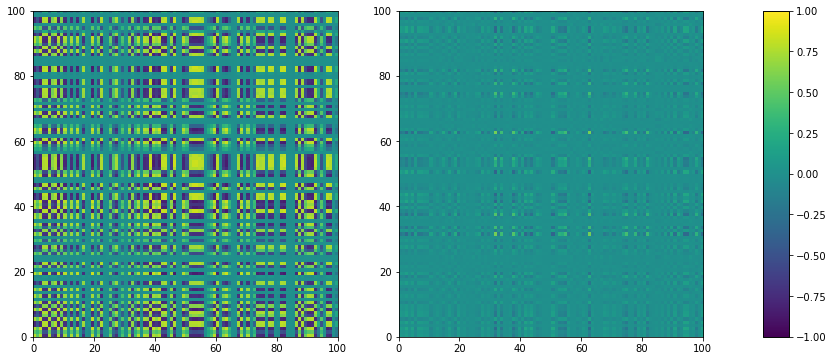

In [39]:
np.random.seed(19680801)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
#divider = make_axes_locatable(ax)
cax = fig.add_axes([.97, .125, .03, .755])
im = ax1.imshow(cov_mat,
               origin='lower', extent=[0, 100, 0, 100], 
               vmax=1, vmin=-1, aspect='auto')
cbar = fig.colorbar(im, cax)

im = ax2.imshow(sp_cov_mat,
               origin='lower', extent=[0, 100, 0, 100], 
               vmax=1, vmin=-1, aspect='auto')
cbar = fig.colorbar(im, cax)

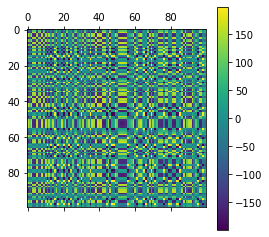

In [42]:
plt.matshow(RC.M.todense())
plt.colorbar()

In [85]:
A = M_seq[9, 40].copy()
eps = 0.1

In [86]:
for i in range(100):
    for j in range(100):
        if abs(A[i, j]) > 100 and abs(A[j, i] + A[i, j]) < eps:
            print('1')
            A[i, j] = 0

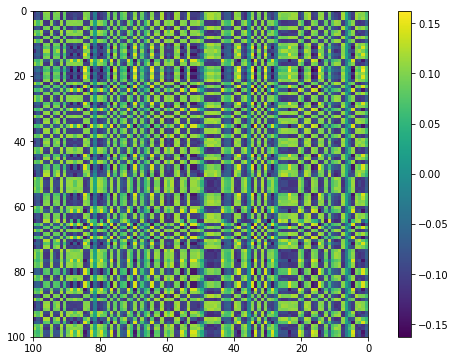

In [55]:
np.random.seed(19680801)

fig, ax = plt.subplots(figsize=(6,6))
divider = make_axes_locatable(ax)
cax = fig.add_axes([.97, .125, .03, .755])
im = ax.imshow(M_dense,
               origin='upper', extent=[100, 0, 100, 0], 
                vmax=M_dense.max(), vmin=M_dense.min(), aspect='auto')

cbar = fig.colorbar(im, cax)

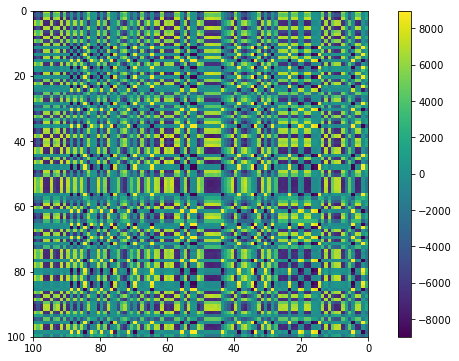

In [74]:
np.random.seed(19680801)

fig, ax = plt.subplots(figsize=(6,6))
divider = make_axes_locatable(ax)
cax = fig.add_axes([.97, .125, .03, .755])
im = ax.imshow(M_seq[9, 40],
               origin='upper', extent=[100, 0, 100, 0], 
                vmax=M_seq[9, 40].max(), vmin=M_seq[9, 40].min(), aspect='auto')

cbar = fig.colorbar(im, cax)